In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Dropout
from keras.optimizers.legacy import Adam
from keras.layers import Input
from keras.models import Model

from sklearn import preprocessing
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from sklearn.preprocessing import KBinsDiscretizer

# Create a label encoder
lb_encoder = LabelEncoder()

# Load the German credit card data
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data_original = pd.read_csv('german.data', names = names, delimiter=' ')

In [2]:
data = data_original.copy()
num_col = ["duration","creditamount", "installmentrate", "residencesince", "age","existingcredits","peopleliable"]
edge_col = []

for col in num_col:    
    est = KBinsDiscretizer(n_bins=4, encode='ordinal', 
                       strategy='uniform')
    data[col] = est.fit_transform(data[[col]])
    for i, edges in enumerate(est.bin_edges_):
        edge_col.append(edges)
        

for item in data.columns:
    if item not in num_col:
        print(item)
        data[item] = lb_encoder.fit_transform(data[item])   

existingchecking
credithistory
purpose
savings
employmentsince
statussex
otherdebtors
property
otherinstallmentplans
housing
job
telephone
foreignworker
classification


# Random Forest for feature selection

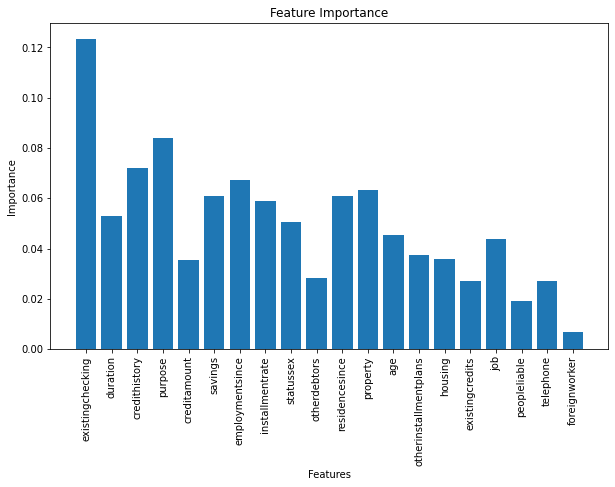

Top Features:
['existingchecking', 'purpose', 'credithistory', 'employmentsince', 'property', 'savings', 'residencesince', 'installmentrate', 'duration', 'statussex', 'age', 'job', 'otherinstallmentplans', 'housing', 'creditamount', 'otherdebtors']


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming 'target_variable' is the name of your target variable
target_variable = 'classification'

# Encode categorical variables if needed
# You may need to preprocess categorical data into numerical format if your dataset contains categorical features

# Separate the target variable
X = data.drop(target_variable, axis=1)
y = data[target_variable]

# Train a Random Forest classifier
model = RandomForestClassifier()
model.fit(X, y)

# Get feature importance scores
feature_importance = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Choose a threshold for feature selection (e.g., top N features)
num_features_to_select = 16  # Number of top features to select

# Get the indices of the top N features
top_feature_indices = feature_importance.argsort()[-num_features_to_select:][::-1]

# Get the names of the top N features
top_features_random_forest = X.columns[top_feature_indices]
print("Top Features:")
print(top_features_random_forest.tolist())


# Modelling and Comparing Accuracy for Different Feature Selection Technique

# Random Forest

In [4]:
import torch, os
import tenseal as ts
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense


salt = os.urandom(16)
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from base64 import urlsafe_b64encode, urlsafe_b64decode

def encrypt_deterministic(key, plaintext):
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    encryptor = cipher.encryptor()
    data_to_encrypt = str(plaintext).encode()
    padded_plaintext = data_to_encrypt.ljust(16) # Pad to block size (16 bytes for AES)
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return urlsafe_b64encode(ciphertext)

def decrypt_deterministic(key, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.ECB(), backend=default_backend())
    decryptor = cipher.decryptor()
    decrypted = decryptor.update(urlsafe_b64decode(ciphertext)) + decryptor.finalize()
    return decrypted.rstrip(b'\0') # Remove padding

# Generate a proper AES key using PBKDF2
password = b'password'
salt = salt
kdf = PBKDF2HMAC(
algorithm=hashes.SHA256(),
iterations=100000,
salt=salt,
    length=32, # Key size for AES-256
    backend=default_backend()
    )
key = kdf.derive(password)

In [5]:
X = data[top_features_random_forest.tolist()]
Y = data["classification"]

encrypted_df = X.apply(lambda x: x.apply(lambda y: encrypt_deterministic(key, y)))
X_hot = pd.get_dummies(encrypted_df, columns=encrypted_df.columns)
encrypted_df_hot = X_hot.copy()
       
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_hot,Y, test_size=0.2)

In [6]:
#batch the data
batch_size = 50
num_batches = len(encrypted_df_hot) / batch_size
encrypted_batches = [encrypted_df_hot[i:i + batch_size] for i in range(0,len(encrypted_df_hot), batch_size)]
tot_columns = encrypted_df_hot.shape[1]
print(tot_columns)

70


# GAN Implementation using Tenseal

In [7]:
#Define Generator
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256, input_dim=encrypted_df_hot.shape[1]))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=encrypted_df_hot.shape[1], activation='sigmoid'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return generator

#Define discriminator
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=256, input_dim=encrypted_df_hot.shape[1]))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=encrypted_df_hot.shape[1], activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator

# create GAN
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(encrypted_df_hot.shape[1],))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss= 'binary_crossentropy', optimizer='adam')
    gan.summary()
    return gan

#define GAN model
def train_gan(gan, generator, discriminator, epochs=1, batch_size=50):
    
    for e in range(epochs):
        print("In epoch :::::::::::::::::::::::::::::::::::::::::::::::::: ", e)
        i=0
        for batch in encrypted_batches:
            i = i +1
            print("In batch no :::::::::::::::::::::::::::::::::::::::::::::::::: ", i)
            noise = np.random.normal(0,1,[batch_size,tot_columns])
            generated_data = generator.predict(noise)
            
            real_data = batch
            #real_data = np.stack(real_data, axis=0)
            discriminator.trainable = True
            real_loss= discriminator.train_on_batch(real_data,np.ones((batch_size,tot_columns)))#Compute the discriminator's loss on real data
            fake_loss= discriminator.train_on_batch(generated_data,np.zeros((batch_size,tot_columns))) #Compute the discriminator's loss on fake data
            print("real_loss : ", real_loss)
            print("fake_loss : ", fake_loss)
            
            discriminator.trainable = False #Don't change discriminator weights
            loss = gan.train_on_batch(noise, np.ones((batch_size,tot_columns)))
            #loss, accuracy = gan.train_on_batch(X_test, y_test)
            print(loss)

In [8]:
#create the models
generator = create_generator()
discriminator = create_discriminator()
#train GAN model
gan = create_gan(discriminator, generator)
train_gan(gan,generator, discriminator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70)]              0         
                                                                 
 sequential (Sequential)     (None, 70)                746822    
                                                                 
 sequential_1 (Sequential)   (None, 70)                299078    
                                                                 
Total params: 1045900 (3.99 MB)
Trainable params: 746822 (2.85 MB)
Non-trainable params: 299078 (1.14 MB)
_________________________________________________________________
In epoch ::::::::::::::::::::::::::::::::::::::::::::::::::  0
In batch no ::::::::::::::::::::::::::::::::::::::::::::::::::  1
2/2 [==============================] - 0s 3ms/step
real_loss :  0.6931976079940796
fake_loss :  0.714285671710968
0.6888530254364014
In batch no :::::::::::

# Training NN without GAN

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class BinaryClassifier(nn.Module):
    def __init__(self, in_columns):
        super(BinaryClassifier, self).__init__()
        '''self.layer1 = nn.Linear(in_columns, 256, bias=True)
        self.layer2 = nn.Linear(256, 1024, bias=True)
        self.layer3 = nn.Linear(1024, 512, bias=True)
        self.layer4 = nn.Linear(512, 256, bias=True)
        self.layer5 = nn.Linear(256, 1, bias=True)'''
        self.layer1 = nn.Linear(in_columns, 256, bias=True)
        self.layer2 = nn.Sequential(nn.Linear(256, 1024, bias=True), nn.Dropout(0.1))
        self.layer3 = nn.Sequential(nn.Linear(1024, 512, bias=True), nn.Dropout(0.1))
        self.layer4 = nn.Sequential(nn.Linear(512, 256, bias=True), nn.Dropout(0.1))
        self.layer5 = nn.Linear(256, 1, bias=True)
        

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.sigmoid(self.layer5(x))
        return x

# Create an instance of the model
model = BinaryClassifier(X_train.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
#optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training loop
epochs = 1000

for epoch in range(epochs):
    # Forward pass
    y_pred = model(torch.tensor(X_train.values, dtype=torch.float32))
    
    # Modify the target tensor
    y_train_tn = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

    # Calculate the loss
    loss = criterion(y_pred, y_train_tn)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

# Test the model
with torch.no_grad():
    y_pred = model(torch.tensor(X_test.values, dtype=torch.float32))
    y_pred_binary = (y_pred >= y_pred.mean()).int()

Epoch [100/1000], Loss: 0.6004142165184021
Epoch [200/1000], Loss: 0.593498945236206
Epoch [300/1000], Loss: 0.5820443630218506
Epoch [400/1000], Loss: 0.5522283911705017
Epoch [500/1000], Loss: 0.49457523226737976
Epoch [600/1000], Loss: 0.4621390104293823
Epoch [700/1000], Loss: 0.4343376159667969
Epoch [800/1000], Loss: 0.406296044588089
Epoch [900/1000], Loss: 0.3589590787887573
Epoch [1000/1000], Loss: 0.35206496715545654


In [23]:
encrypted_df_hot.shape

(1000, 70)

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

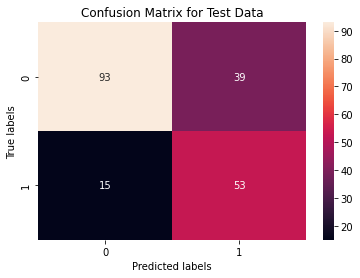

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as pt
import seaborn as sbn

con_mat = confusion_matrix(y_test, y_pred_binary)
ax= pt.subplot()
sbn.heatmap(con_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Test Data')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

In [11]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.86      0.70      0.78       132
           1       0.58      0.78      0.66        68

    accuracy                           0.73       200
   macro avg       0.72      0.74      0.72       200
weighted avg       0.76      0.73      0.74       200



# Generate Synthetic Data and Train

In [12]:
tot_columns

70

In [13]:
import numpy as np
import torch

# Assuming your GAN's generator is named "generator"
def generate_synthetic_data(generator, num_samples, noise_dim):
    noise = np.random.normal(0, 1, [num_samples, noise_dim])
    generated_data = generator.predict(noise)
    return generated_data

# Create synthetic data using the trained GAN
num_samples = X_train.shape[0]  # Generate as many synthetic samples as real samples
noise_dim = tot_columns  # Assuming noise dimension is same as number of columns in encrypted_df_hot
synthetic_data = generate_synthetic_data(generator, num_samples, noise_dim)

# Combine the real and synthetic data
combined_X = np.vstack((X_train.values, synthetic_data))
combined_y = np.concatenate((y_train.values, y_train.values))  # Assuming you want same distribution for synthetic data

# Convert data to PyTorch tensors
X_tensor = torch.tensor(combined_X, dtype=torch.float32)
y_tensor = torch.tensor(combined_y, dtype=torch.float32).view(-1, 1)

# Define your BinaryClassifier and training loop as before
model = BinaryClassifier(combined_X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
epochs = 1000
for epoch in range(epochs):
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

# Test the model as before
with torch.no_grad():
    y_pred = model(torch.tensor(X_test.values, dtype=torch.float32))
    y_pred_binary = (y_pred >= 0.5).int()  # Using 0.5 as threshold here for binary classification


25/25 [==============================] - 0s 2ms/step
Epoch [100/1000], Loss: 0.6033375263214111
Epoch [200/1000], Loss: 0.6005458235740662
Epoch [300/1000], Loss: 0.600118100643158
Epoch [400/1000], Loss: 0.5986826419830322
Epoch [500/1000], Loss: 0.5970531702041626
Epoch [600/1000], Loss: 0.594976007938385
Epoch [700/1000], Loss: 0.5913342833518982
Epoch [800/1000], Loss: 0.585355281829834
Epoch [900/1000], Loss: 0.5753982067108154
Epoch [1000/1000], Loss: 0.5609719157218933


In [ ]:
y_pred

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

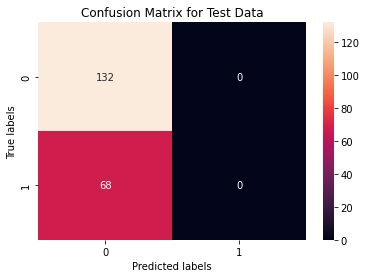

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as pt
import seaborn as sbn

con_mat = confusion_matrix(y_test, y_pred_binary)
ax= pt.subplot()
sbn.heatmap(con_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Test Data')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

In [16]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       132
           1       0.00      0.00      0.00        68

    accuracy                           0.66       200
   macro avg       0.33      0.50      0.40       200
weighted avg       0.44      0.66      0.52       200



C:\Users\chanc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chanc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chanc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XG BOOST 

In [17]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
target_variable = 'classification'

# Encode categorical variables if needed
# You may need to preprocess categorical data into numerical format if your dataset contains categorical features

# Separate the target variable
X = data.drop(target_variable, axis=1)
y = data[target_variable]

# Train an XGBoost model
model = xgb.XGBClassifier()
model.fit(X, y)

# Plot feature importance
plot_importance(model)
plt.show()

# Get feature importance scores
feature_importance = model.feature_importances_

# Choose a threshold for feature selection (e.g., top N features)
num_features_to_select = 15  # Number of top features to select

# Get the indices of the top N features
top_feature_indices = feature_importance.argsort()[-num_features_to_select:][::-1]

# Get the names of the top N features
top_features_xgboost = X.columns[top_feature_indices]
print("Top Features:")
print(top_features_xgboost.tolist())

In [ ]:
X = data[top_features_xgboost.tolist()]
Y = data["classification"]

encrypted_df = X.apply(lambda x: x.apply(lambda y: encrypt_deterministic(key, y)))
X_hot = pd.get_dummies(encrypted_df, columns=encrypted_df.columns)
encrypted_df_hot = X_hot.copy()
encrypted_df_hot["classification"] = Y
       
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_hot,Y, test_size=0.2)

In [ ]:
encrypted_batches = [encrypted_df_hot[i:i + batch_size] for i in range(0,len(encrypted_df_hot), batch_size)]
tot_columns = encrypted_df_hot.shape[1]
print(tot_columns)

In [ ]:
#Define Generator
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256, input_dim=encrypted_df_hot.shape[1]))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=encrypted_df_hot.shape[1], activation='sigmoid'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return generator

#Define discriminator
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=256, input_dim=encrypted_df_hot.shape[1]))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=encrypted_df_hot.shape[1], activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator

# create GAN
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(encrypted_df_hot.shape[1],))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss= 'binary_crossentropy', optimizer='adam')
    gan.summary()
    return gan

#define GAN model
def train_gan(gan, generator, discriminator, epochs=1, batch_size=50):
    
    for e in range(epochs):
        print("In epoch :::::::::::::::::::::::::::::::::::::::::::::::::: ", e)
        i=0
        for batch in encrypted_batches:
            i = i +1
            print("In batch no :::::::::::::::::::::::::::::::::::::::::::::::::: ", i)
            noise = np.random.normal(0,1,[batch_size,tot_columns])
            generated_data = generator.predict(noise)
            
            real_data = batch
            #real_data = np.stack(real_data, axis=0)
            discriminator.trainable = True
            real_loss= discriminator.train_on_batch(real_data,np.ones((batch_size,tot_columns)))#Compute the discriminator's loss on real data
            fake_loss= discriminator.train_on_batch(generated_data,np.zeros((batch_size,tot_columns))) #Compute the discriminator's loss on fake data
            print("real_loss : ", real_loss)
            print("fake_loss : ", fake_loss)
            
            discriminator.trainable = False #Don't change discriminator weights
            loss = gan.train_on_batch(noise, np.ones((batch_size,tot_columns)))
            #loss, accuracy = gan.train_on_batch(X_test, y_test)
            print(loss)

In [ ]:
#create the models
generator = create_generator()
discriminator = create_discriminator()
#train GAN model
gan = create_gan(discriminator, generator)
train_gan(gan,generator, discriminator)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class BinaryClassifier(nn.Module):
    def __init__(self, in_columns):
        super(BinaryClassifier, self).__init__()
        '''self.layer1 = nn.Linear(in_columns, 256, bias=True)
        self.layer2 = nn.Linear(256, 1024, bias=True)
        self.layer3 = nn.Linear(1024, 512, bias=True)
        self.layer4 = nn.Linear(512, 256, bias=True)
        self.layer5 = nn.Linear(256, 1, bias=True)'''
        self.layer1 = nn.Linear(in_columns, 256, bias=True)
        self.layer2 = nn.Sequential(nn.Linear(256, 1024, bias=True), nn.Dropout(0.1))
        self.layer3 = nn.Sequential(nn.Linear(1024, 512, bias=True), nn.Dropout(0.1))
        self.layer4 = nn.Sequential(nn.Linear(512, 256, bias=True), nn.Dropout(0.1))
        self.layer5 = nn.Linear(256, 1, bias=True)
        

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = torch.sigmoid(self.layer5(x))
        return x

# Create an instance of the model
model = BinaryClassifier(X_train.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
#optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training loop
epochs = 1000

for epoch in range(epochs):
    # Forward pass
    y_pred = model(torch.tensor(X_train.values, dtype=torch.float32))
    
    # Modify the target tensor
    y_train_tn = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

    # Calculate the loss
    loss = criterion(y_pred, y_train_tn)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

# Test the model
with torch.no_grad():
    y_pred = model(torch.tensor(X_test.values, dtype=torch.float32))
    y_pred_binary = (y_pred >= y_pred.mean()).int()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as pt
import seaborn as sbn

con_mat = confusion_matrix(y_test, y_pred_binary)
ax= pt.subplot()
sbn.heatmap(con_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for Test Data')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

In [ ]:
print(classification_report(y_test, y_pred_binary))